<a href="https://colab.research.google.com/github/tatz210588/Tatz_Thesis/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.9 MB/s eta 0:00:00


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from skimage import morphology

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [4]:
from google.colab import drive
drive.mount('/content/drive')
INPUT_FOLDER = "drive/MyDrive/Colab Notebooks/Thesis/"

Mounted at /content/drive


In [26]:
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [27]:
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(f"{path}/{s}") for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

In [28]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

In [29]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max

    return window_image

In [30]:
def remove_noise(arr, display=False):
    #medical_image = dicom.read_file(file_path)
    #medical_image = plt.imread(file_path)
    #image = medical_image.pixel_array

    #hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(arr, 40, 80)

    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)

    label_count = np.bincount(labels.ravel().astype(np.int))
    label_count[0] = 0

    mask = labels == label_count.argmax()

    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))

    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final Image')
        plt.axis('off')

    return masked_image

number of slices:  253
AMC-001.jpeg


<ipython-input-30-76bbcc3ba394>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_count = np.bincount(labels.ravel().astype(np.int))
<ipython-input-30-76bbcc3ba394>:19: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  mask = ndimage.morphology.binary_fill_holes(mask)


<Figure size 640x480 with 0 Axes>

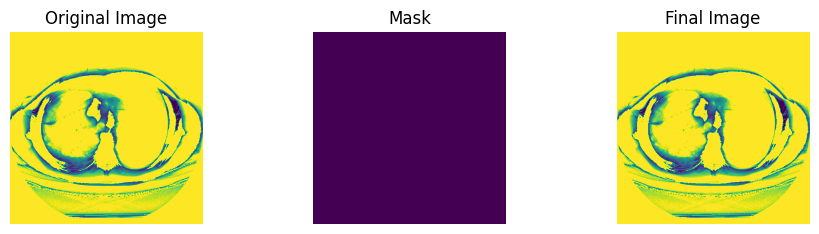

number of slices:  253
AMC-002.jpeg


<ipython-input-30-76bbcc3ba394>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_count = np.bincount(labels.ravel().astype(np.int))
<ipython-input-30-76bbcc3ba394>:19: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  mask = ndimage.morphology.binary_fill_holes(mask)


<Figure size 640x480 with 0 Axes>

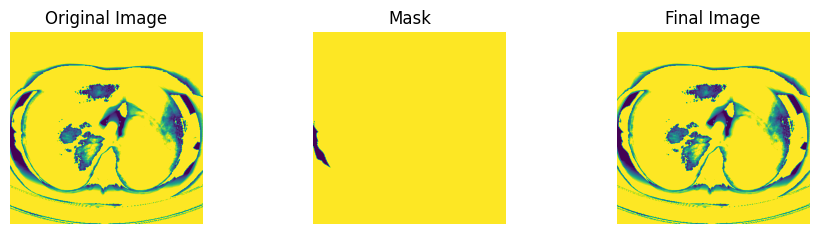

In [32]:
# fig,axs = plt.subplots(1,2,figsize=(15,5))
for patient in patients:
    path = INPUT_FOLDER + patient
    patient_slices = load_scan(path)
    stacked_slices = get_pixels_hu(patient_slices)

    N=len(stacked_slices)
    print ("number of slices: ", N)
    arr = np.zeros((512, 512), np.int16)
    count = 3
    for im in stacked_slices:
        smallest = np.amin(im)
        biggest = np.amax(im)

        #imarr = np.array(im, dtype=np.int16)
        arr = arr + (1 - im) * np.log(count)/(biggest - smallest)

        #print ((N * 14)/ np.log10(count))
        count = count + 1
        #arr = np.array(np.round(arr), dtype=np.uint8)
        arr = np.array(np.round(arr),dtype=np.uint8)
    #out=Image.fromarray(arr, mode='L')

    imName = patient + ".jpeg"
    plt.savefig(imName)
    print(imName)
    _ = remove_noise(arr, display=True)
    #plt.imshow(arr, cmap=plt.cm.gray)
    # axs[1].hist(arr.ravel(),bins=50)
    plt.show()
# out.save(imName)
# plt.show()

In [50]:
arr

array([[250, 247, 248, ..., 249, 249, 246],
       [248, 247, 244, ..., 248, 249, 249],
       [249, 249, 247, ..., 249, 249, 249],
       ...,
       [225, 220, 226, ..., 227, 229, 231],
       [225, 223, 226, ..., 224, 223, 228],
       [230, 229, 230, ..., 226, 224, 223]], dtype=uint8)

In [ ]:
def crop_image(image, display=False):
  mask = image == 0


In [20]:
brain_image = window_image(arr, 40, 80)

In [21]:
type(brain_image)

numpy.ndarray